# Anime Recommendation with Matrix Factorization

Data from https://www.kaggle.com/CooperUnion/anime-recommendations-database

In [1]:
import logging
import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.distributions import constraints
from torch.autograd import Variable
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.optim as optim

from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, Predictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

from eval_metrics import rmse, mae
from utils import *
from GaussianMF import run_GaussianMF
from PoissonMF import run_PoissonMF
from visualization import *

from sklearn.model_selection import train_test_split

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.4.0')

In [2]:
%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

## Read in data and Train Test Split
Now we have a matrix without any missing value. To evaluate performance of the model, we dig some random values out to be test data. Since we have $100 \times 200 = 20000$ values in total, we dig out $2000$ values to be test data.

In [52]:
anime_data, anime_matrix_train, anime_data_test = load_makematrix("data/ratings_100_200_real.csv", split=True)

In [4]:
anime_matrix_train.shape

(100, 200)

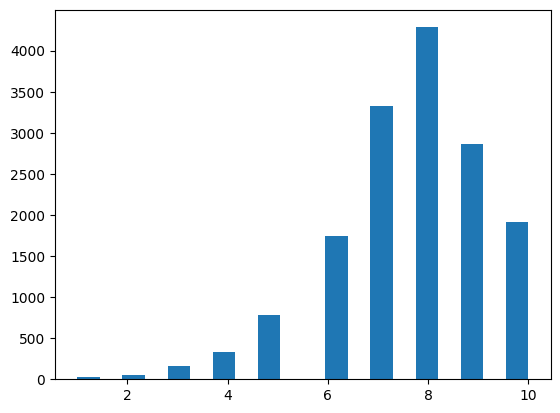

In [7]:
# Plot the distribution of ratings
plt.hist(anime_data.rating, bins=20)
plt.show()
# Many -1's

In [8]:
# Mean of ratings without -1's
print('The mean of ratings is', np.mean(anime_data[anime_data.rating > 0].rating))
print('The standard deviation of ratings is', np.std(anime_data[anime_data.rating > 0].rating))

The mean of ratings is 7.6670970240784975
The standard deviation of ratings is 1.5856381149038559


In [5]:
# Known paramters
sigma_u = torch.tensor(1.0)
sigma_v = torch.tensor(1.0)

# Dimension of latent vectors
k = 30

## Boox Loop iter 1

### Model: Normal

In [21]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

#### MAP Inference

In [10]:
loss_list, mae_list = run_GaussianMF(anime_matrix_train, anime_data_test, k = k, method="map", mae_tol = 0.05)

[iter 0]  loss: 88107957.1728 Test MAE: 7.6335
[iter 250]  loss: 9710353.9180 Test MAE: 7.6335
[iter 500]  loss: 9703657.6773 Test MAE: 7.6335
[iter 750]  loss: 9703656.7566 Test MAE: 7.6335
[iter 1000]  loss: 9703656.7566 Test MAE: 7.6335
[iter 1250]  loss: 9703656.7566 Test MAE: 7.6335
[iter 1500]  loss: 9703656.6993 Test MAE: 7.6335
[iter 1750]  loss: 9703656.6707 Test MAE: 7.6335


#### MAP Criticism

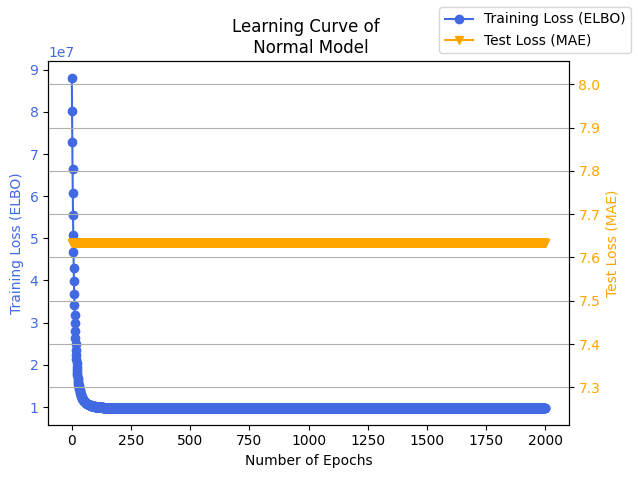

In [17]:
learning_curve_plot(loss_list, mae_list)

#### SVI Inference

In [40]:
loss_list, mae_list = run_GaussianMF(anime_matrix_train, anime_data_test, k = k, method = "svi", mae_tol = 0.02)

[iter 0]  loss: 168894882.5039 Test MAE: 7.6332
[iter 250]  loss: 5996485.3684 Test MAE: 0.9696
[iter 500]  loss: 4873891.0625 Test MAE: 0.9023
[stop at iter 504]  loss: 4825559.0039 Test MAE: 0.9287


#### SVI Criticism

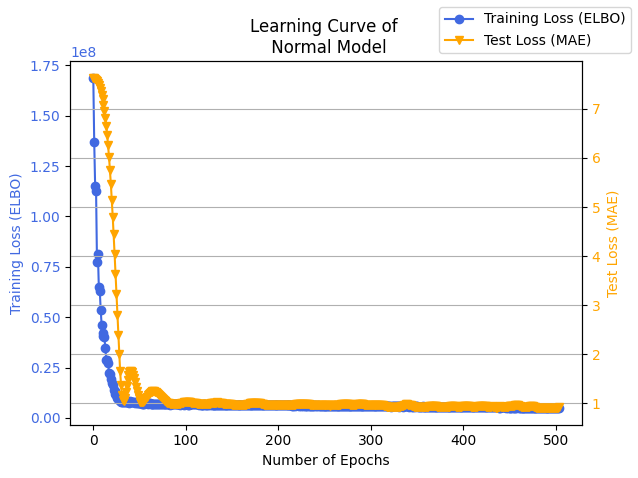

In [20]:
learning_curve_plot(loss_list, mae_list)

In [21]:
R = torch.mm(pyro.param("u_mean"), pyro.param("v_mean").t())
print(f'SVI estimate of R: {torch.mm(pyro.param("u_mean"), pyro.param("v_mean").t())}')

SVI estimate of R: tensor([[ 7.5021,  5.8325,  5.6572,  ...,  6.8153,  7.8675,  8.5787],
        [ 9.1793,  9.2292,  9.3649,  ...,  8.8388, 10.1325, 10.9313],
        [ 7.5158,  7.6007,  7.8465,  ...,  6.3319,  7.0913,  7.9486],
        ...,
        [ 8.1259,  7.6331,  7.5488,  ...,  7.1623,  7.8088,  8.6252],
        [ 8.3122,  7.8839,  7.7903,  ...,  7.7570,  8.2684,  9.1614],
        [ 8.2058,  7.2644,  7.0296,  ...,  7.8542,  8.6324,  9.4381]],
       grad_fn=<MmBackward>)


Let us observe the posterior distribution over the different latent variables in the model.

In [22]:
print('The MAE is', mae_list[-1])

The MAE is 0.9193001553320116


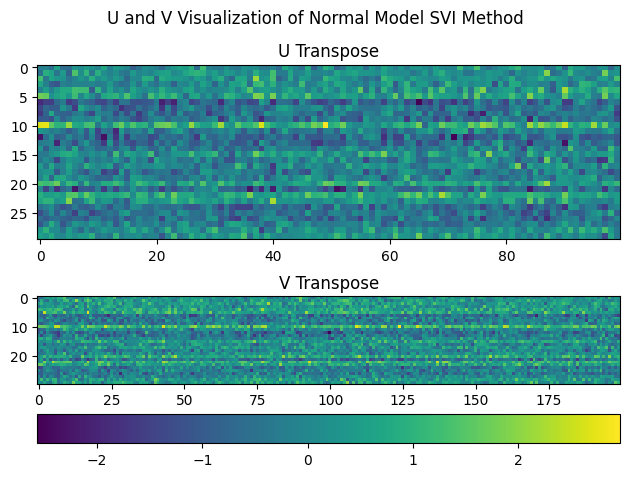

In [25]:
import visualization
importlib.reload(visualization)
from visualization import U_V_visualization
U_V_visualization()

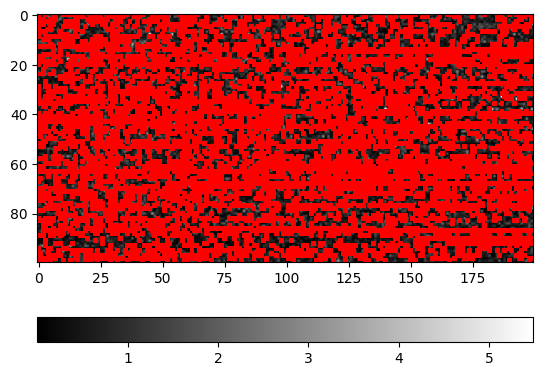

In [53]:
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')
R = anime_matrix_train.values
plt.imshow(abs(R - torch.mm(pyro.param("u_mean"), pyro.param("v_mean").t()).detach().numpy()))
plt.colorbar(orientation="horizontal")
plt.gray()
plt.show()

#### HMC Inference

In [ ]:
import GaussianMF
import importlib
importlib.reload(GaussianMF)
from GaussianMF import run_GaussianMF

hmc_samples = run_GaussianMF(anime_matrix_train, anime_data_test, k = k, mae_tol = 0.02, method = "hmc")

## Box Loop iter 2

### Model: Poisson

#### SVI Inference

In [14]:
loss_list, mae_list = run_PoissonMF(anime_matrix_train, anime_data_test, k = k, mae_tol = 0.02)

[iter 0]  loss: 72030853.9433 Test MAE: 7.6334
[stop at iter 140]  loss: 44872276.6930 Test MAE: 3.5563


In [ ]:
import PoissonMF
import importlib
importlib.reload(PoissonMF)
from PoissonMF import run_PoissonMF

hmc_samples = run_PoissonMF(anime_matrix_train, anime_data_test, k = k, mae_tol = 0.02, method = "hmc")

In [ ]:
for site, values in hmc_samples.items():
    print("Site: {}".format(site))
    print(values, "\n")

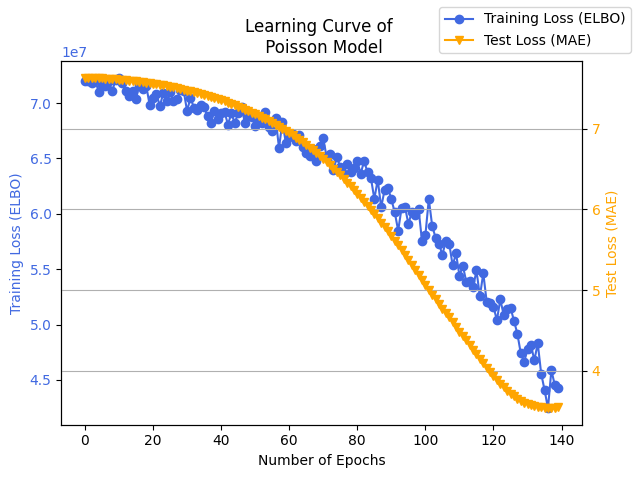

In [17]:
learning_curve_plot(loss_list, mae_list, title="Learning Curve of \n Poisson Model")

#### SVI Criticism

In [175]:
R = torch.mm(pyro.param("u_mean"), pyro.param("v_mean").t())
print(f'SVI estimate of R: {R}')

SVI estimate of R: tensor([[ 2.8349,  2.8523,  2.5805,  ...,  1.6315,  2.4674,  0.6492],
        [10.8649, 15.0990,  7.6284,  ...,  8.3135,  8.6207,  6.1664],
        [ 5.6852,  4.8423,  1.6253,  ...,  3.7235,  3.1849,  1.8803],
        ...,
        [ 2.5767,  4.0041,  3.1127,  ...,  4.2122,  3.0690,  1.7469],
        [ 8.1993, 10.4046,  6.4601,  ...,  7.5809,  7.7248,  2.9380],
        [ 7.6319,  8.3845,  6.8667,  ...,  6.0736,  6.8040,  1.6539]],
       grad_fn=<MmBackward>)


In [176]:
print('The MAE is', mae_list[-1])

The MAE is 3.4037980685695524


## HMC

In contrast to using variational inference which gives us an approximate posterior over our latent variables, we can also do exact inference using [Markov Chain Monte Carlo](http://docs.pyro.ai/en/dev/mcmc.html) (MCMC), a class of algorithms that in the limit, allow us to draw unbiased samples from the true posterior. The algorithm that we will be using is called the No-U Turn Sampler (NUTS) \[1\], which provides an efficient and automated way of running Hamiltonian Monte Carlo.  It is slightly slower than variational inference, but provides an exact estimate.

In [16]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:27, 43.63it/s, step size=3.41e-01, acc. prob=0.932]


In [17]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%      25%       50%       75%      95%
0  9.186877  0.138838  8.958779  9.09328  9.189491  9.274171  9.42897 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.859916  0.223591 -2.225528 -2.020191 -1.854385 -1.707892 -1.517022 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0 -0.187301  0.078942 -0.314141 -0.238675 -0.186967 -0.131882 -0.054502 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.359185  0.129782  0.147538  0.277808  0.358398  0.442401  0.568684 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.952456  0.053048  0.871549  0.916451  0.951075  0.984877  1.048475 



## Comparing Posterior Distributions

Let us compare the posterior distribution of the latent variables that we obtained from variational inference with those from Hamiltonian Monte Carlo. As can be seen below, for Variational Inference, the marginal distribution of the different regression coefficients is under-dispersed w.r.t. the true posterior (from HMC). This is an artifact of the *KL(q||p)* loss (the KL divergence of the true posterior from the approximate posterior) that is minimized by Variational Inference.

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from variational inference. Note that since our variational family has diagonal covariance, we cannot model any correlation between the latents and the resulting approximation is overconfident (under-dispersed)

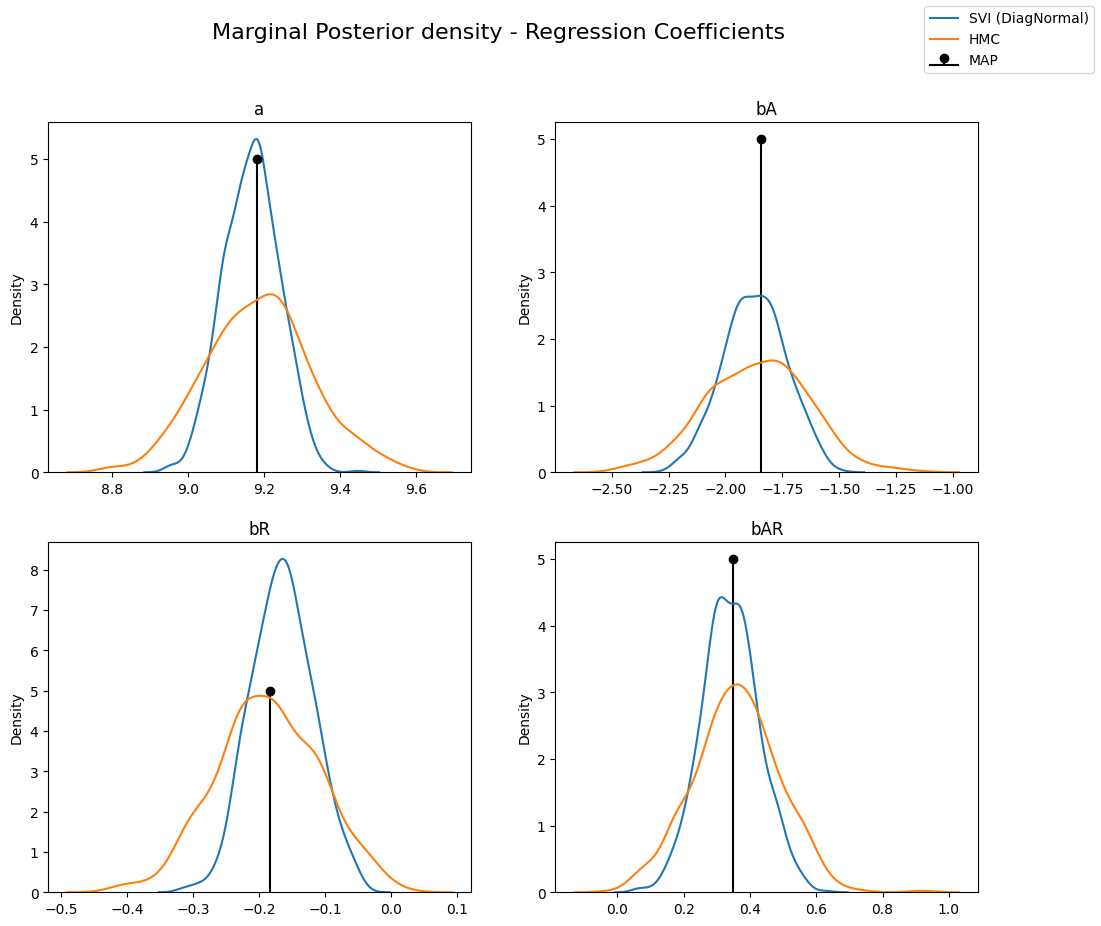

In [18]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.kdeplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)", color='tab:blue', alpha=0.2)
    sns.kdeplot(hmc_samples[site], ax=ax, label="HMC", color="tab:orange", alpha=0.2)
    ax.stem([map_estimates[site]], [5], label="MAP", markerfmt="ko", basefmt='k', linefmt='k')
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

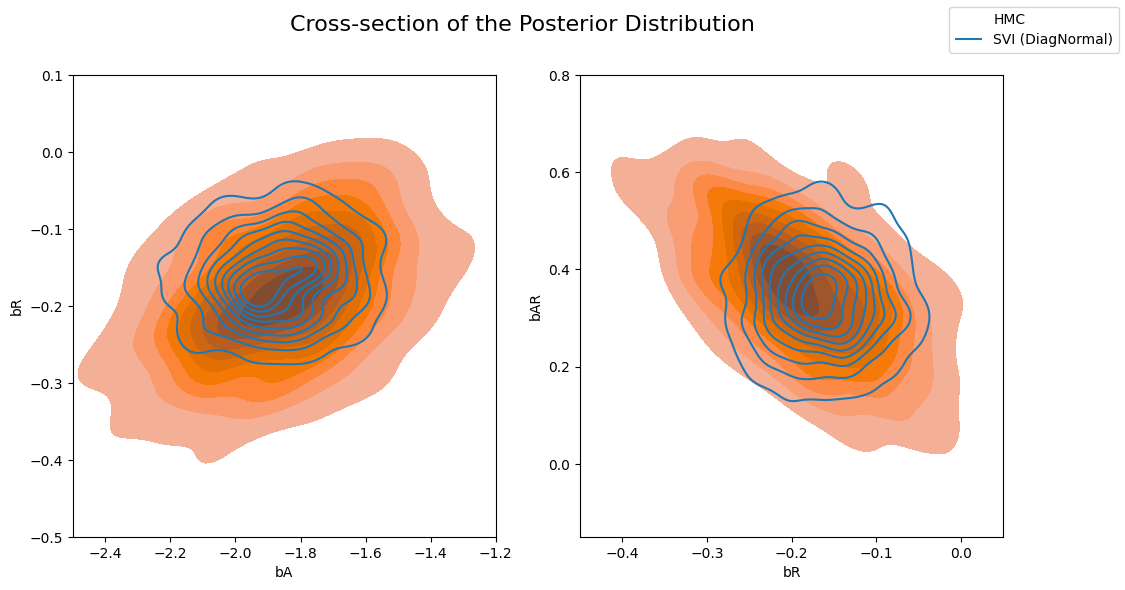

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC", color="tab:orange")
sns.kdeplot(svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC", color="tab:orange")
sns.kdeplot(svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## MultivariateNormal Guide

As comparison to the previously obtained results from Diagonal Normal guide, we will now use a guide that generates samples from a Cholesky factorization of a multivariate normal distribution.  This allows us to capture the correlations between the latent variables via a covariance matrix.  If we wrote this manually, we would need to combine all the latent variables so we could sample a Multivarite Normal jointly.

In [20]:
from pyro.infer.autoguide.initialization import init_to_mean

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

train_via_opt(model, guide, lr=0.01)

[iter 0]  loss: 681.1718
[iter 250]  loss: 531.3409
[iter 500]  loss: 431.2437
[iter 750]  loss: 359.1847
[iter 1000]  loss: 266.1722
[iter 1250]  loss: 249.1281
[iter 1500]  loss: 248.6330
[iter 1750]  loss: 248.0745


Let's look at the shape of the posteriors again.  You can see the multivariate guide is able to capture more of the true posterior.

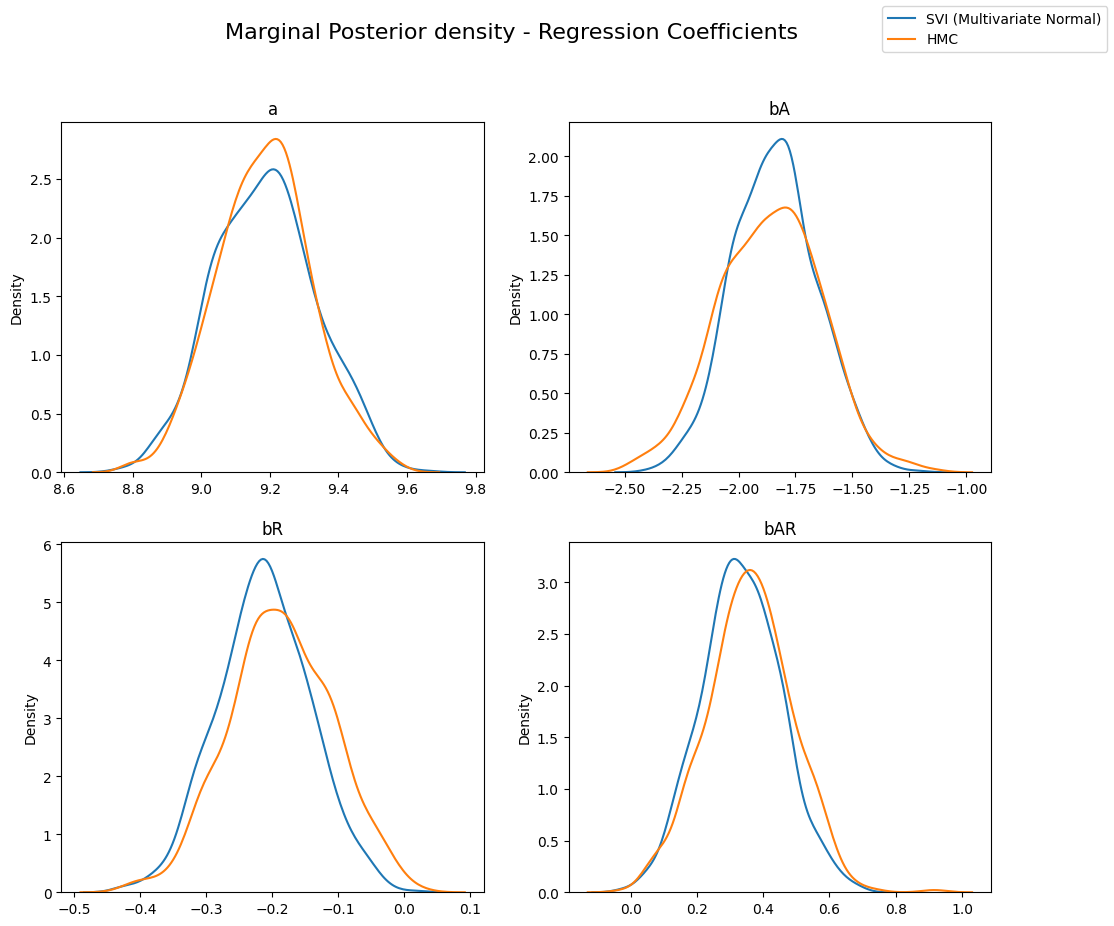

In [21]:
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_mvn_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
                   for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
                   if k != "obs"}
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.kdeplot(svi_mvn_samples[site], ax=ax, label="SVI (Multivariate Normal)")
    sns.kdeplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

Now let's compare the posterior computed by the Diagonal Normal guide vs the Multivariate Normal guide.  Note that the multivariate distribution is more dispresed than the Diagonal Normal.

and the Multivariate guide with the posterior computed by HMC.  Note that the Multivariate guide better captures the true posterior.

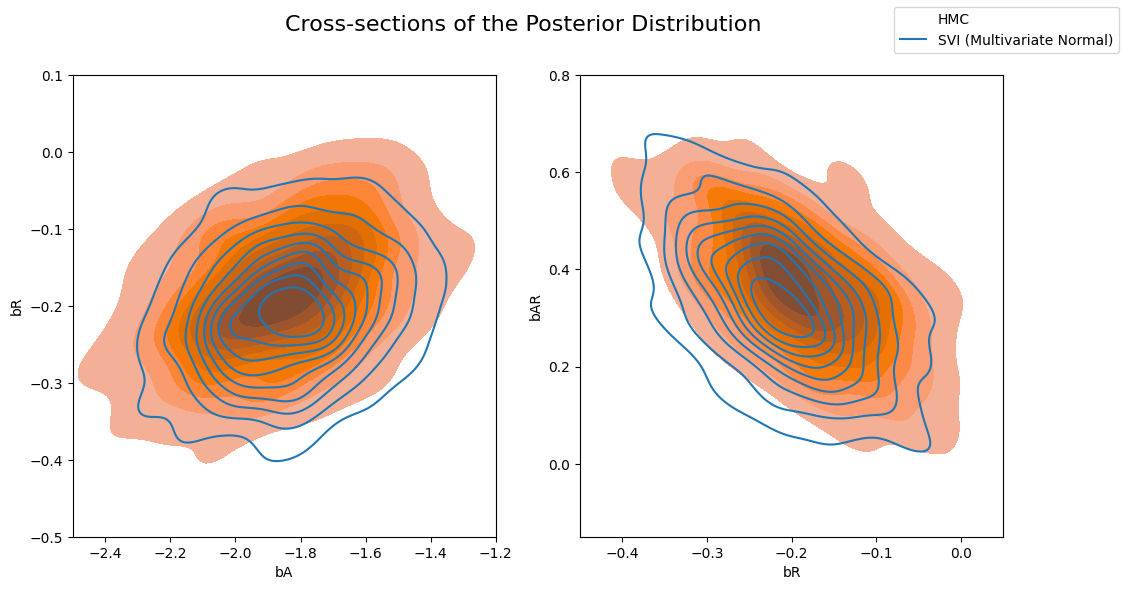

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC", color="tab:orange")
sns.kdeplot(svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC", color="tab:orange")
sns.kdeplot(svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## References
[1] Hoffman, Matthew D., and Andrew Gelman. "The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo." Journal of Machine Learning Research 15.1 (2014): 1593-1623.  https://arxiv.org/abs/1111.4246.